In [103]:
!pip install alive-progress

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import astropy
from tqdm import tqdm
from alive_progress import alive_bar
from scipy . interpolate import CubicSpline as cs

# Loading the data

In [105]:
FF=fits.open('reduced/01046965_HRF_FF_ext.fits')[0].data
print(np.shape(FF))

(4608, 55)


# Plotting the data

In [106]:
wavelength=fits.open('reduced/01046985_HRF_TH_ext_wavelengthScale.fits')[0].data
wavelength_scale = np.transpose(wavelength)
np.shape(wavelength_scale)

(4608, 55)

In [107]:
# Finding the wavelength and flux peaks
peak_wavelengths = [wavelength_scale[row_idx, col_idx] for col_idx, row_idx in enumerate(FF.argmax(axis=0))]
peak_fluxes = [FF[row_idx, col_idx] for col_idx, row_idx in enumerate(FF.argmax(axis=0))]

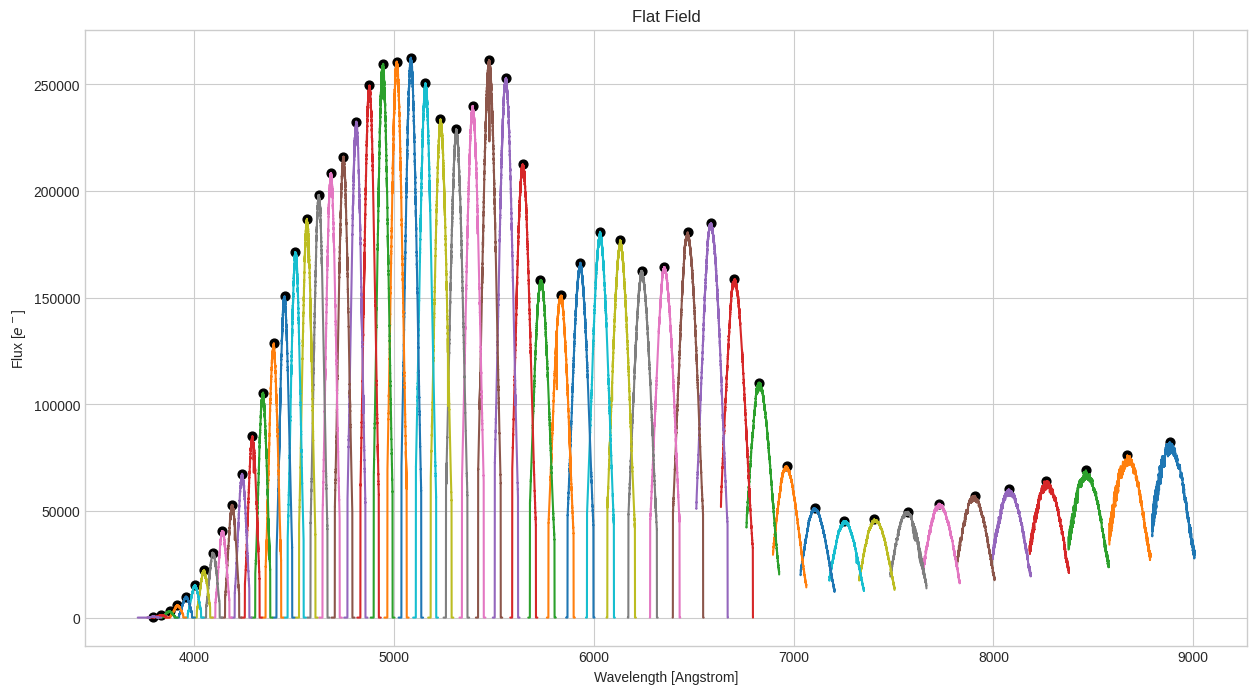

In [108]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 8))  
plt.plot(wavelength_scale, FF)
plt.title('Flat Field')
plt.xlabel('Wavelength [Angstrom]')
plt.scatter(peak_wavelengths, peak_fluxes, color='black', s = 40)
plt.ylabel('Flux [$e^-$]')
plt.show()

# Blaze Theorectical Calculation

In [109]:
theoretical_angle = 69.74*(np.pi/180) # conversion from degree to radians
groove_spacing = 52.67 # gr/mm
distance = (10e7)/groove_spacing #conversion of mm to Angstorm
order_m = np.linspace(40,94,55)
theoretical_blaze = []
#calculation
theoretical_blaze = [2*distance*np.sin(theoretical_angle)/i for i in order_m]

Text(0.5, 0, 'Spectral Order')

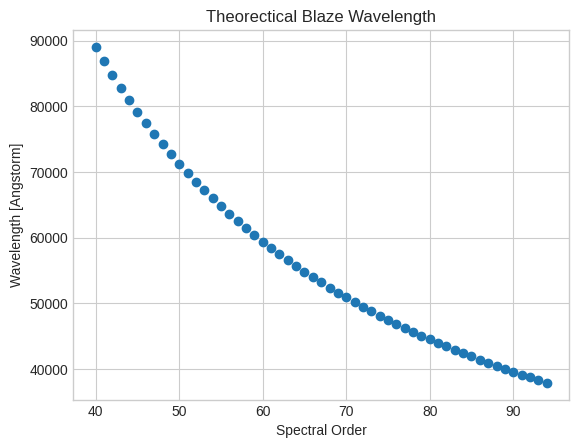

In [110]:
plt.scatter(order_m,theoretical_blaze)
plt.title('Theorectical Blaze Wavelength')
plt.ylabel('Wavelength [Angstorm]')
plt.xlabel('Spectral Order')

# Blaze observed Calculation

In [111]:
from alive_progress import alive_bar

def calculate_blaze_angle(order, wavelength, distance):
    return np.arcsin(order * wavelength / (2 * distance))

def calculate_angle_error(observed_angle, theoretical_angle):
    return 100 * abs(theoretical_angle - observed_angle) / theoretical_angle

def calculate_wavelength_error(observed_wavelength, theoretical_wavelength):
    return 100 * abs(theoretical_wavelength - observed_wavelength) / theoretical_wavelength

theoretical_angle = 69.74 * np.pi / 180
groove_spacing = 52.676
distance = (10**7) / groove_spacing
order_m = np.linspace(40, 94, 55)

theoretical_wavelength = [2 * distance * np.sin(theoretical_angle) / i for i in order_m]

max_flux = []
max_wavelength = []
observed_blaze_angles = []
angle_error = []
wavelength_error = []

with alive_bar(total=len(order_m), force_tty=True) as bar:
    for i, order in enumerate(order_m):
        number_fluxes = FF[:, i]
        number_wavelengths = wavelength_scale[:, i]
        number_flux_index = np.argmax(number_fluxes)
        max_flux.append(number_fluxes[number_flux_index])
        max_wavelength.append(number_wavelengths[number_flux_index])
                        
        blaze_angle = calculate_blaze_angle(order, max_wavelength[i], distance)
        observed_blaze_angles.append(blaze_angle)
            
        ang_err = calculate_angle_error(blaze_angle, theoretical_angle)
        angle_error.append(ang_err)
            
        wav_err = calculate_wavelength_error(max_wavelength[i], theoretical_wavelength[i])
        wavelength_error.append(wav_err)
            
        bar()

observed_blaze_angles = np.array(observed_blaze_angles)
blaze_average = np.mean(observed_blaze_angles)
observed_blaze_angle = blaze_average * 180 / np.pi
average_angle_error = calculate_angle_error(observed_blaze_angle, 69.74)

print('Observed blaze angle is', round(observed_blaze_angle, 2),
          'degrees. Mean error from theoretical blaze angle of 69.74 is',
          round(average_angle_error, 3), '%')


|████████████████████████████████████████| 55/55 [100%] in 0.0s (6706.55/s)     
Observed blaze angle is 69.64 degrees. Mean error from theoretical blaze angle of 69.74 is 0.15 %


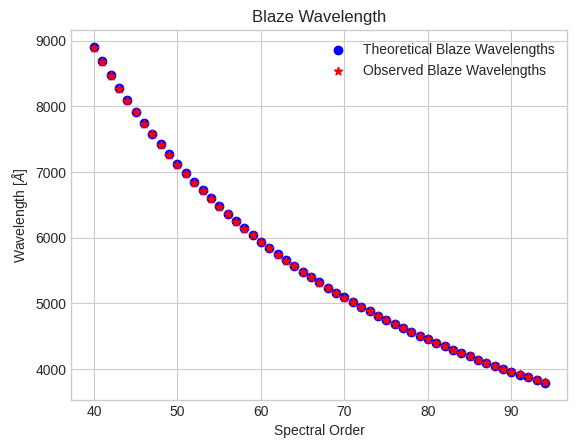

In [112]:
plt.scatter(order_m, theoretical_wavelength, color='blue', marker='o', label='Theoretical Blaze Wavelengths')
plt.scatter(order_m, max_wavelength, color='red', marker='*', label='Observed Blaze Wavelengths')
plt.title('Blaze Wavelength')
plt.xlabel('Spectral Order')
plt.ylabel('Wavelength [$\AA$]')
plt.legend()
plt.show()


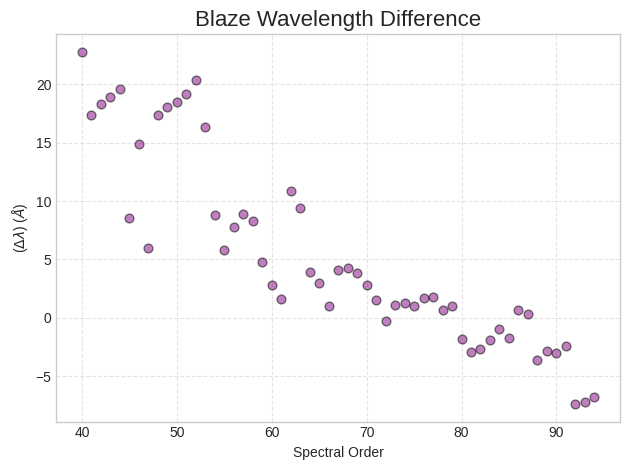

In [113]:
th_wavelengths = np.array(theoretical_wavelength)
obs_wavelengths = np.array(max_wavelength)
plt.scatter(order_m, th_wavelengths - obs_wavelengths, c='purple', s=40, marker='o', edgecolors='black', alpha=0.5)
plt.title('Blaze Wavelength Difference', fontsize=16)
plt.xlabel('Spectral Order')
plt.ylabel('($\Delta\lambda$) ($\AA$)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


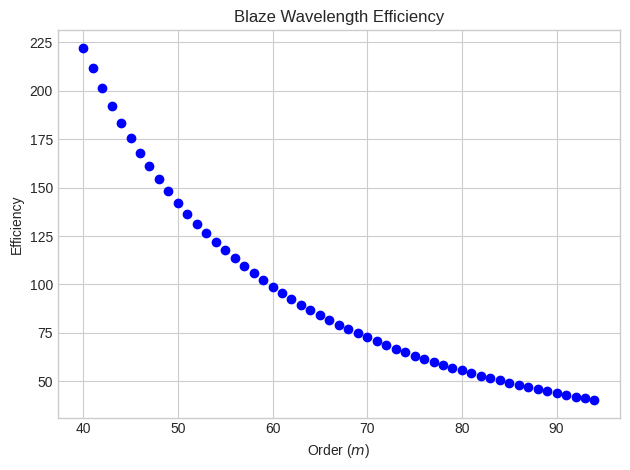

In [114]:
blaze_efficiency = max_wavelength / order_m
plt.scatter(order_m, blaze_efficiency, marker='o', color='blue')
plt.title('Blaze Wavelength Efficiency')
plt.xlabel('Order ($m$)')
plt.ylabel('Efficiency')
plt.tight_layout()  
plt.grid(True)      

plt.show()

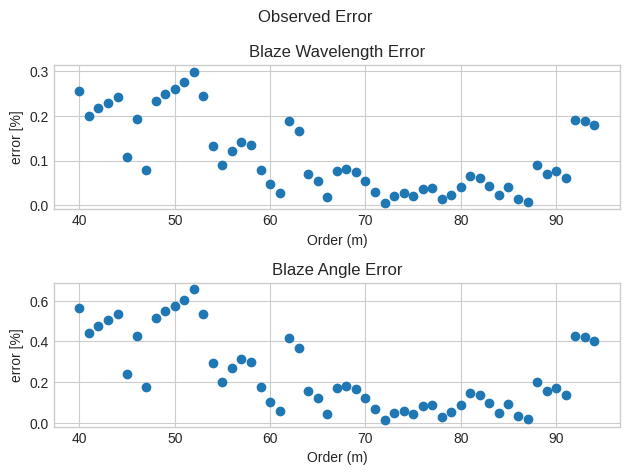

In [115]:
fig,axs = plt.subplots(2)
fig.suptitle('Observed Error')
axs[0].scatter(order_m,wavelength_error)
axs[1].scatter(order_m,angle_error)
axs[0].set(xlabel='Order (m)',ylabel='error [%]')
axs[0].set_title('Blaze Wavelength Error')
axs[1].set_title('Blaze Angle Error')
axs[1].set(xlabel='Order (m)',ylabel='error [%]')
fig.tight_layout()


# FSR

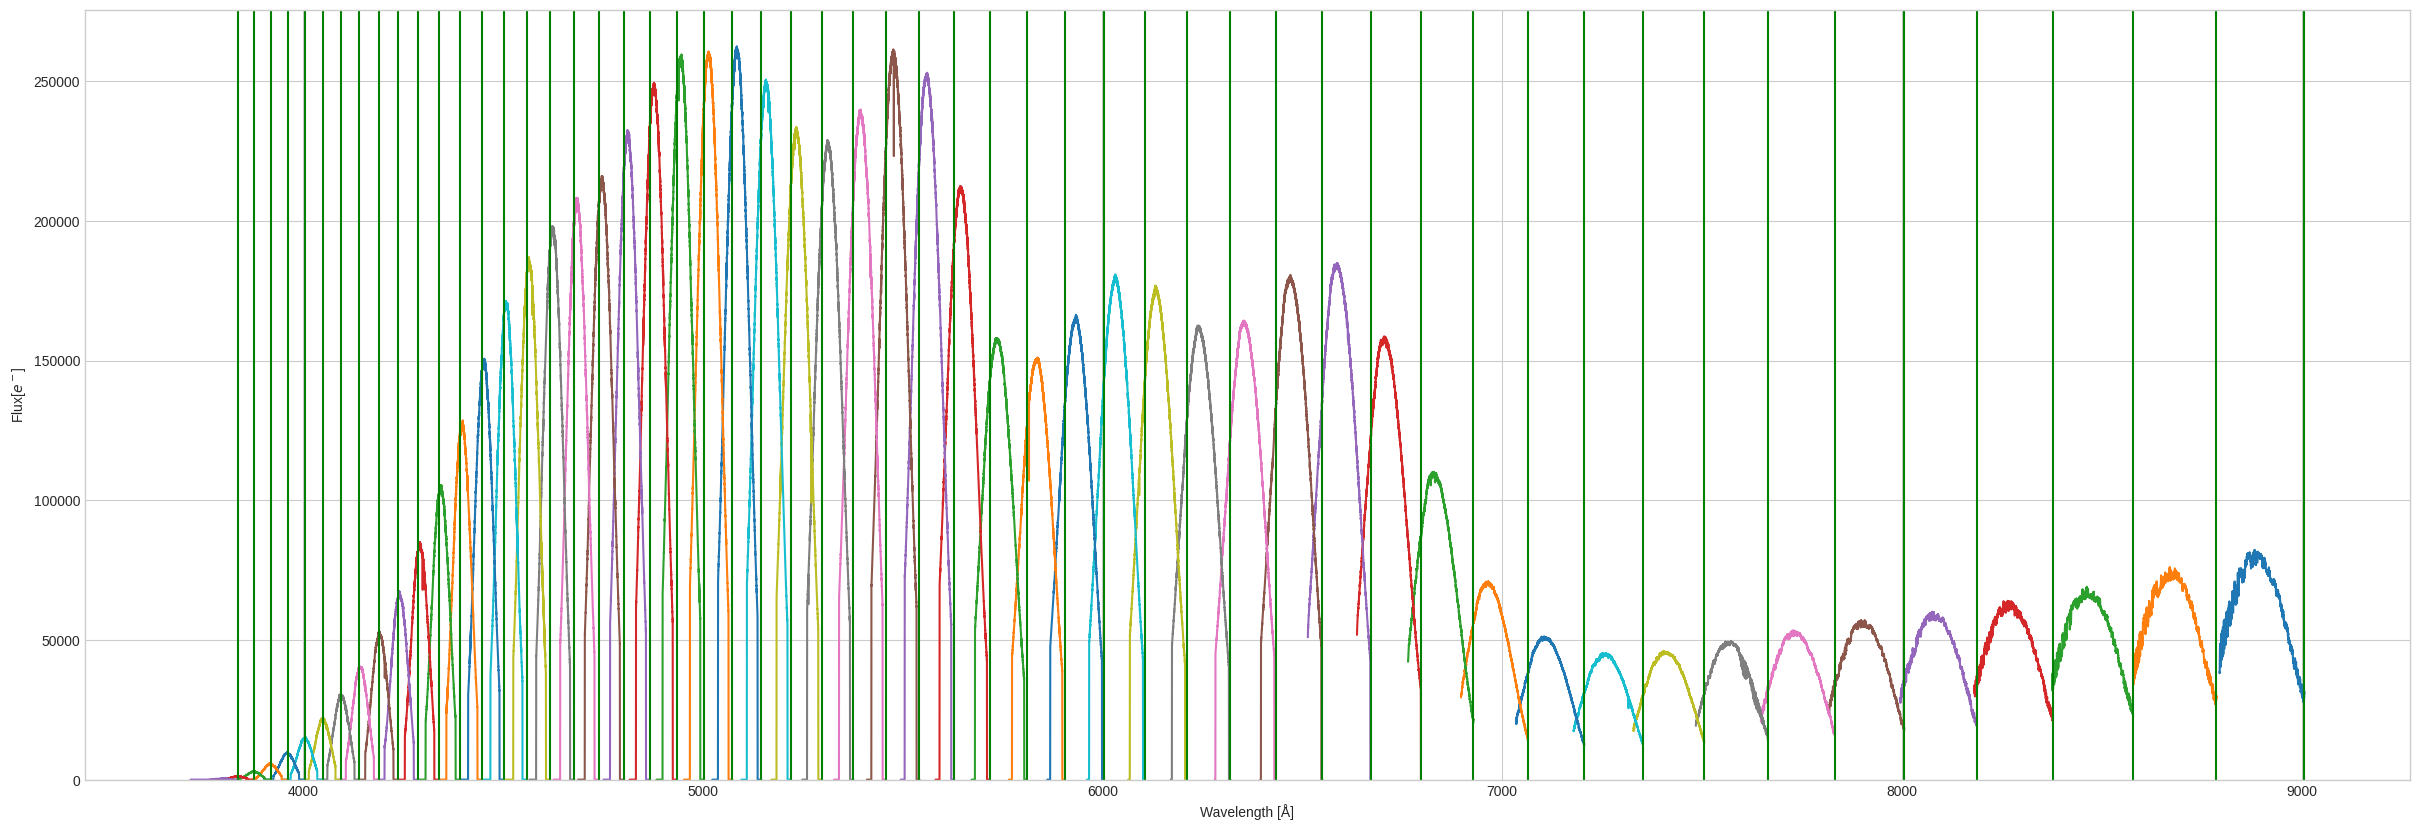

In [116]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
intersect = []
for i in range(54):
    diff = np.abs(FF[:,i] - FF[:,i+1])
    intersect = np.argmin(diff).flatten()
plt.plot(wavelength_scale,FF)
for i in range(55):
    plt.axvline(x= wavelength_scale[intersect[0], i], color = 'g')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux[$e^-$]')

plt.ylim(0)
plt.show()

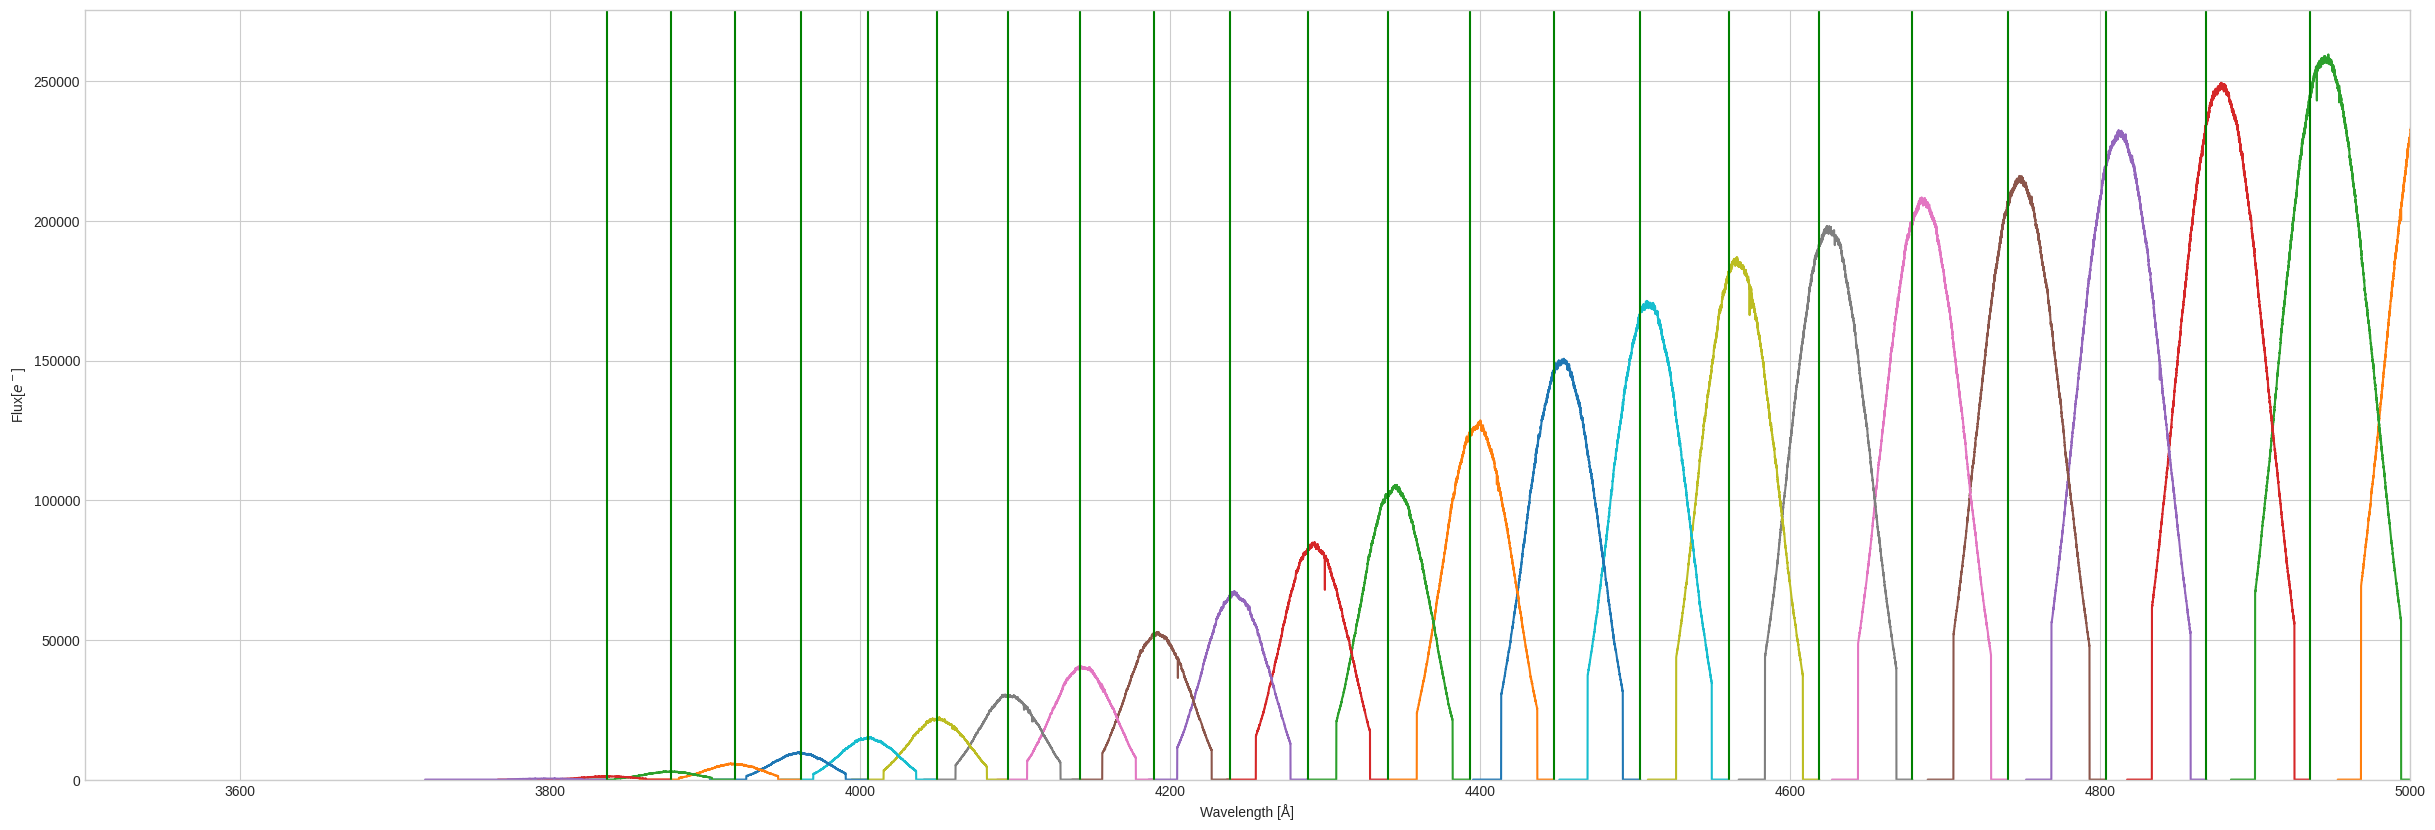

In [117]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
intersect = []
for i in range(54):
    diff = np.abs(FF[:,i] - FF[:,i+1])
    intersect = np.argmin(diff).flatten()
plt.plot(wavelength_scale,FF)
for i in range(55):
    plt.axvline(x= wavelength_scale[intersect[0], i], color = 'g')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux[$e^-$]')
plt.xlim(3500,5000)
plt.ylim(0)
plt.show()

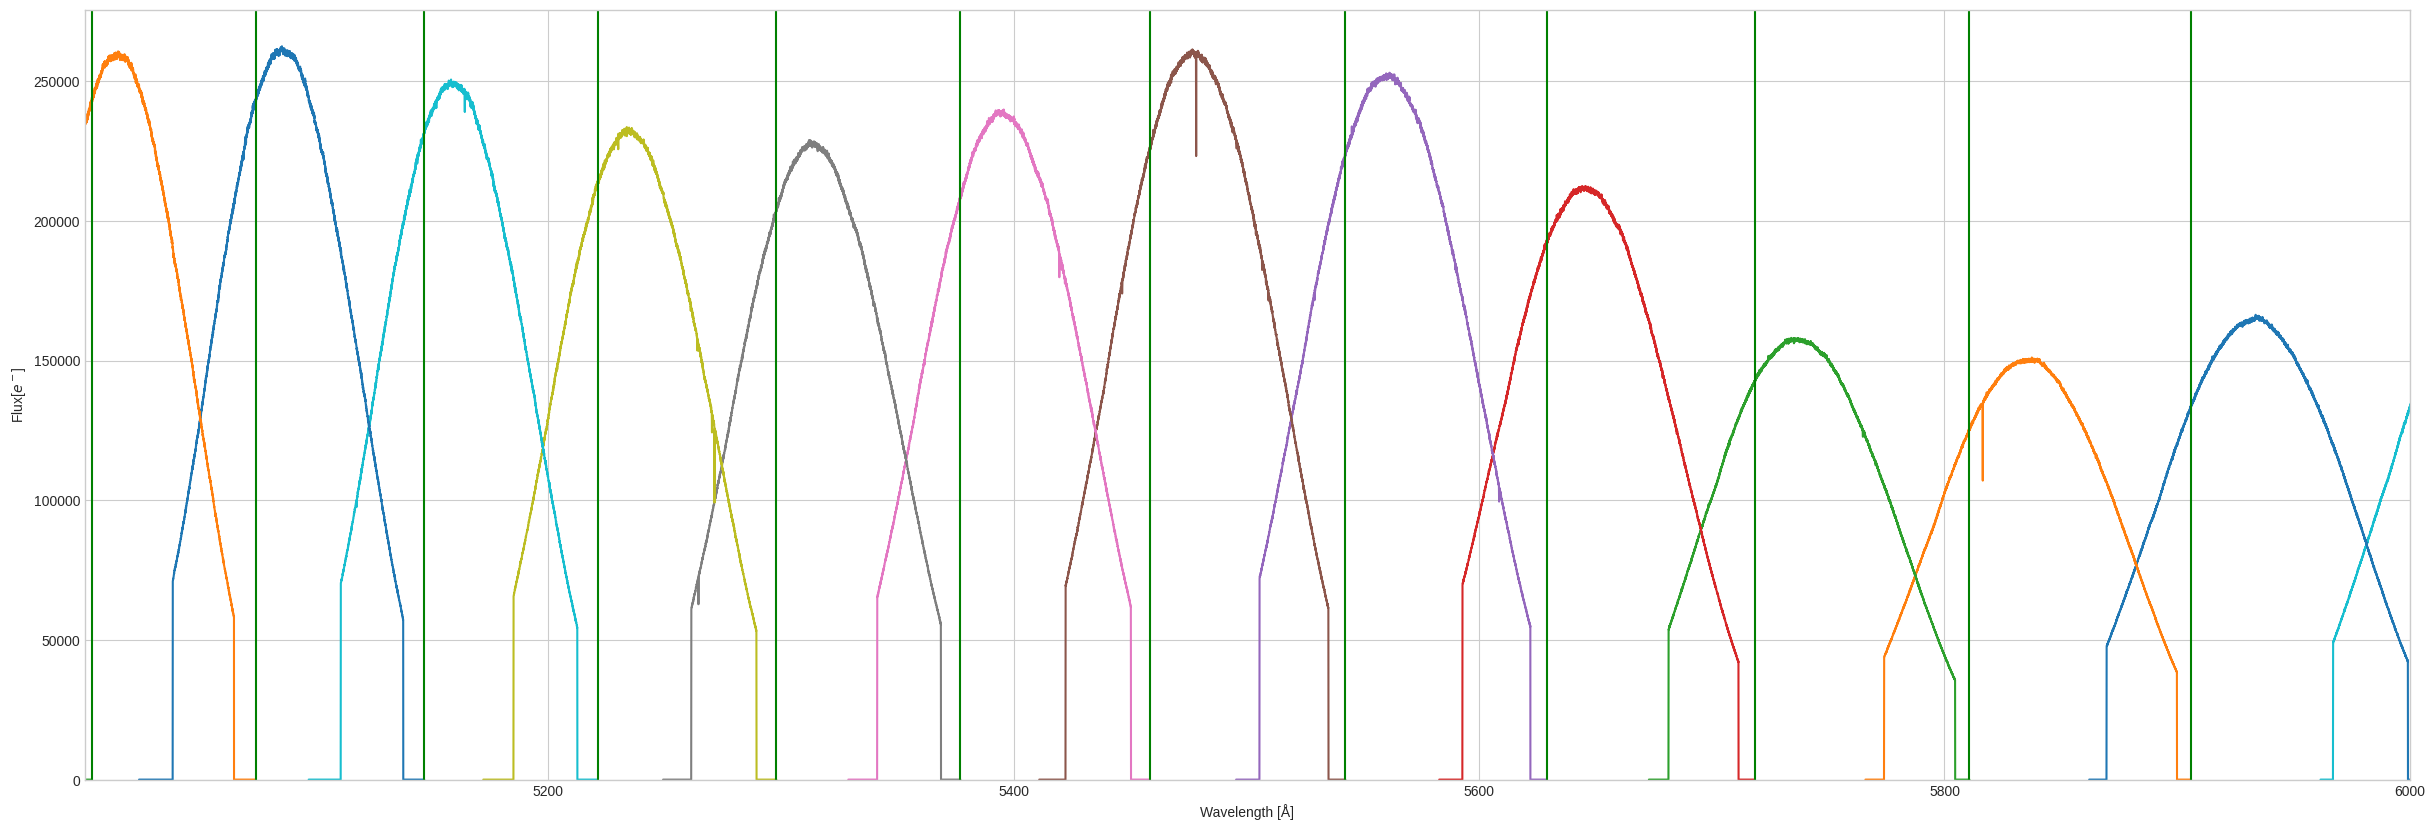

In [118]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
intersect = []
for i in range(54):
    diff = np.abs(FF[:,i] - FF[:,i+1])
    intersect = np.argmin(diff).flatten()
plt.plot(wavelength_scale,FF)
for i in range(55):
    plt.axvline(x= wavelength_scale[intersect[0], i], color = 'g')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux[$e^-$]')
plt.xlim(5001,6000)
plt.ylim(0)
plt.show()

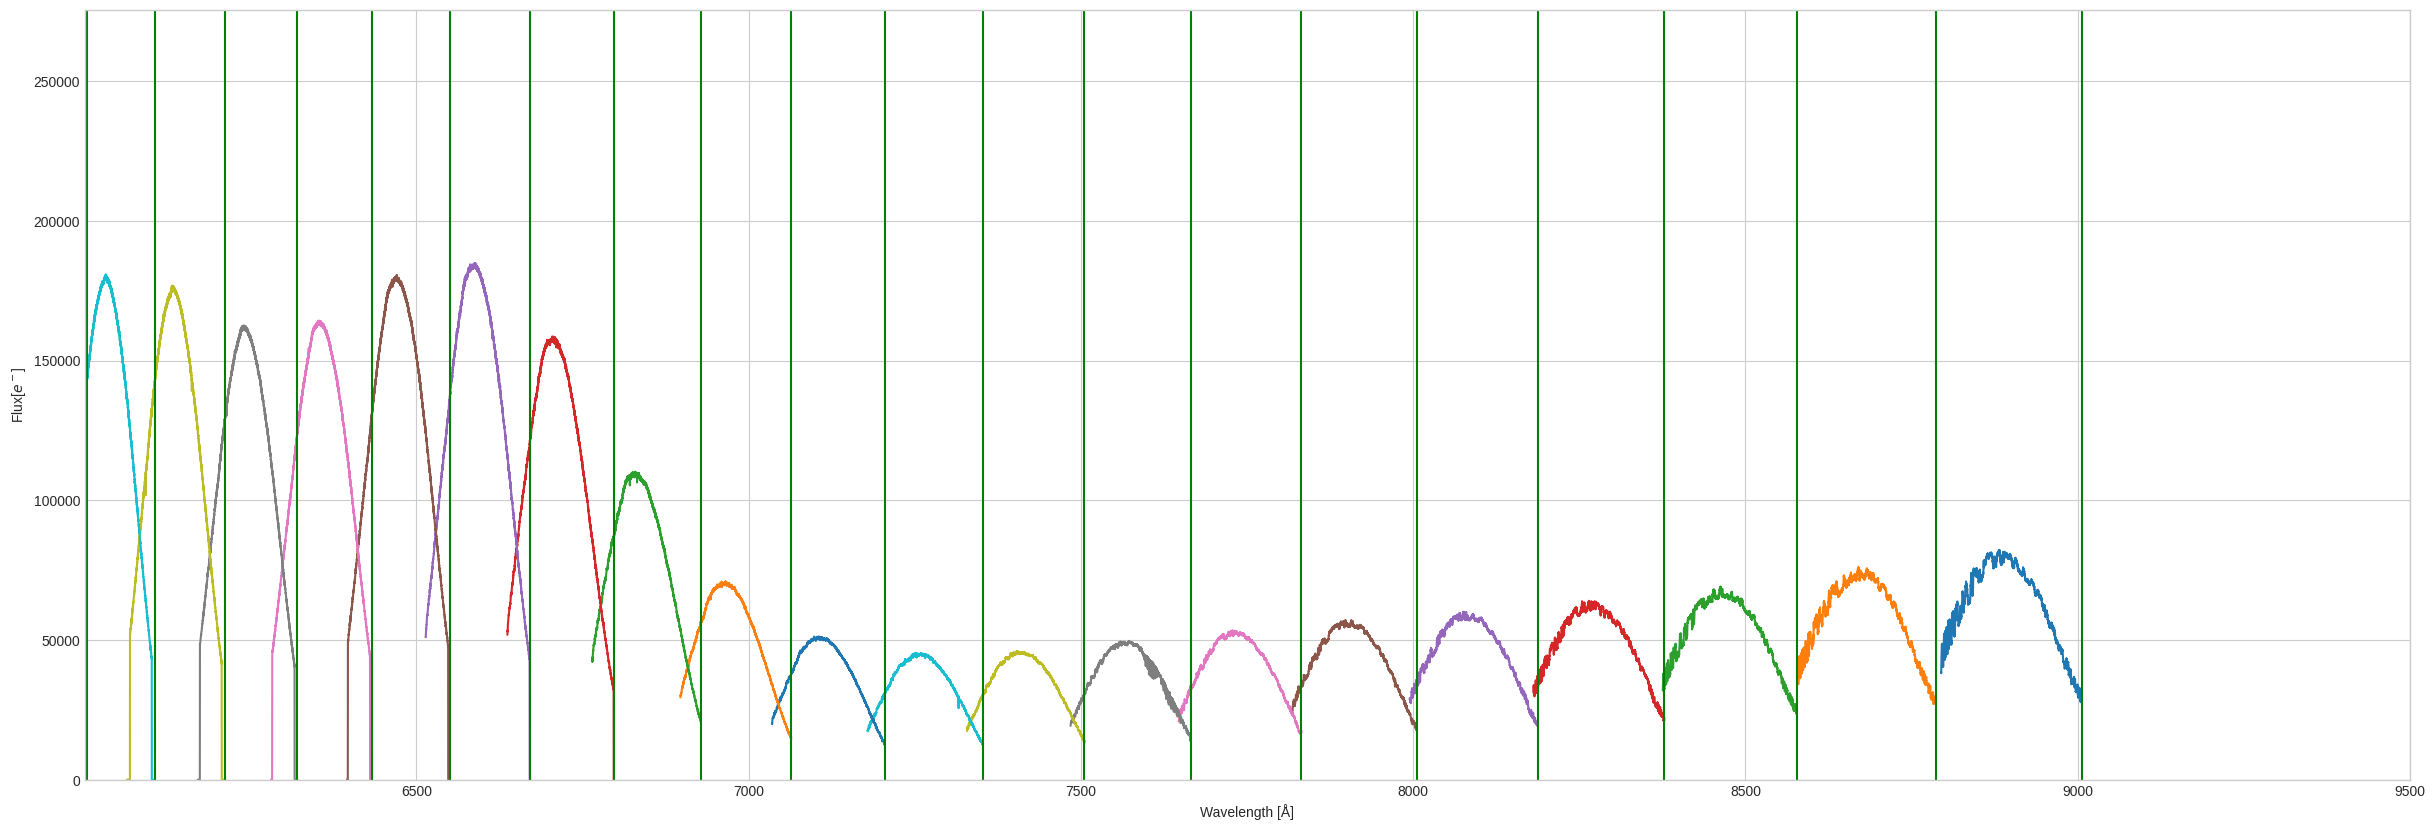

In [119]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
intersect = []
for i in range(54):
    diff = np.abs(FF[:,i] - FF[:,i+1])
    intersect = np.argmin(diff).flatten()
plt.plot(wavelength_scale,FF)
for i in range(55):
    plt.axvline(x= wavelength_scale[intersect[0], i], color = 'g')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux[$e^-$]')
plt.xlim(6001,9500)
plt.ylim(0)
plt.show()

In [120]:
from scipy.interpolate import CubicSpline

overlap = [wavelength_scale[0, 0]]

for i in range(54):
    order1 = i
    order2 = i + 1
    FF1 = FF[:, order1]
    FF2 = FF[:, order2]
    wav1 = wavelength_scale[:, order1]
    wav2 = wavelength_scale[:, order2]
    center = len(FF1) // 2

    cs_pre = CubicSpline(wav1[center:-1][::-1], FF1[center:-1][::-1])
    cs_post = CubicSpline(wav2[0:center][::-1], FF2[0:center][::-1])
    
    wavRange = np.linspace(wav1[center], wav2[center], len(FF1))
    fl1 = cs_pre(wavRange)
    fl2 = cs_post(wavRange)

    index = np.abs(fl1 - fl2).argmin()
    overlap.append(wavRange[index])


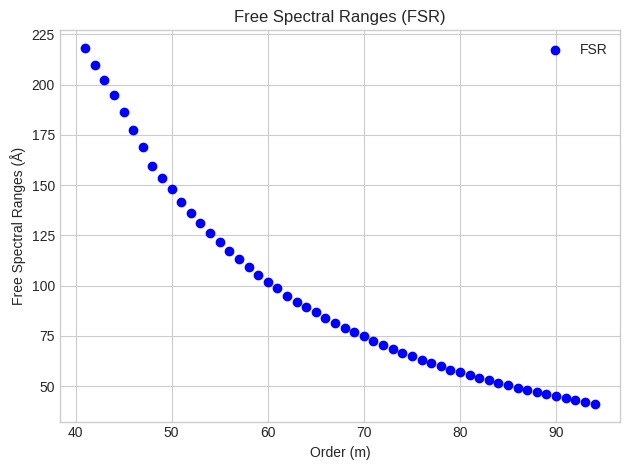

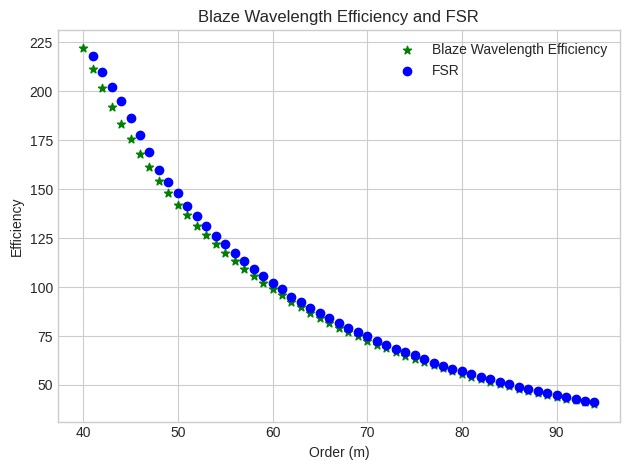

In [121]:
# Calculate FSR
FSR = [overlap[i] - overlap[i + 1] for i in range(len(overlap) - 1)][::-1]

# PLOT 1: FSR
plt.scatter(order_m[1:][::-1], FSR, color='blue', marker='o', label='FSR')
plt.title('Free Spectral Ranges (FSR)')
plt.xlabel('Order (m)')
plt.ylabel('Free Spectral Ranges (Å)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate difference between Blaze Efficiency and FSR
diffBlaze = blaze_efficiency[1:] - FSR[::-1]

# PLOT 2: Blaze Efficiency and FSR
plt.scatter(order_m, blaze_efficiency, color='green', marker='*', label='Blaze Wavelength Efficiency')
plt.scatter(order_m[1:][::-1], FSR, color='blue', marker='o', label='FSR')
plt.title('Blaze Wavelength Efficiency and FSR')
plt.xlabel('Order (m)')
plt.ylabel('Efficiency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


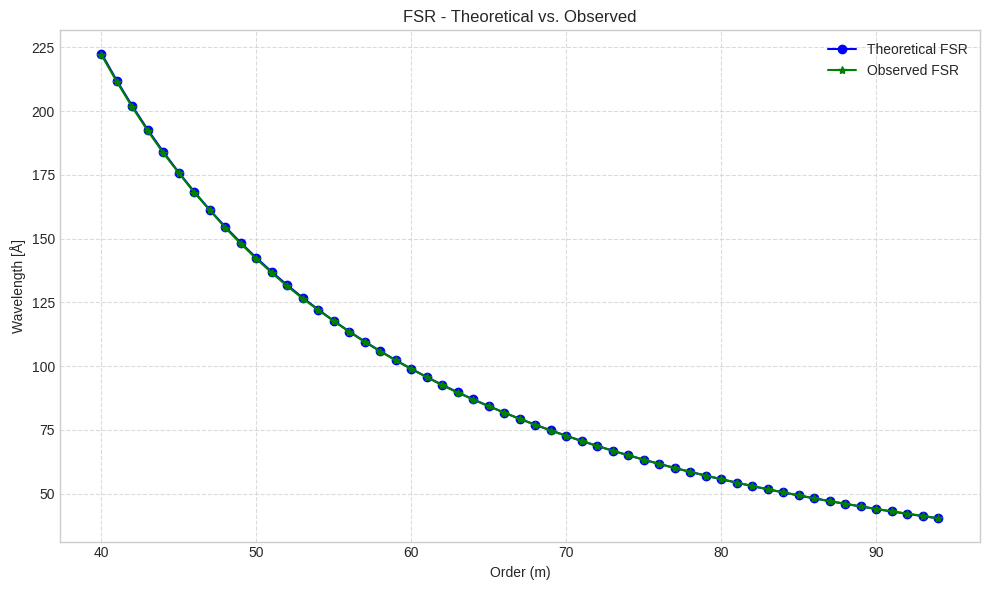

In [122]:
th_wavelengths = np.array(theoretical_wavelength)
obs_wavelengths = np.array(max_wavelength)

plt.figure(figsize=(10, 6))

plt.plot(order_m, th_wavelengths / order_m, label='Theoretical FSR', color='blue', marker='o')
plt.plot(order_m, obs_wavelengths / order_m, label='Observed FSR', color='green', marker='*')

plt.legend()
plt.xlabel("Order (m)")
plt.ylabel("Wavelength [Å]")
plt.title("FSR - Theoretical vs. Observed")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


In [123]:
wavelength=fits.open('reduced/01046985_HRF_TH_ext_wavelengthScale.fits')[0].data
wavelength_scale = np.transpose(wavelength)
np.shape(wavelength_scale)

(4608, 55)

In [124]:
def calculate_efficiency(wavelength, theorectical_efficiency):
  efficiency=np.zeros(6)

  wavelength_ff = np.reshape(wavelength_scale,len(wavelength)*len(wavelength_scale))
  flux_ff = np.reshape(wavelength,len(wavelength)*len(wavelength_scale))

  ETC_wavelengths = [3800,4400,5500,6400,7900,8800]

  flux_efficency = []
  #h = np.zeros(6)

  for a in range(len(ETC_wavelengths)):
    for b in range(55):
      indices = np.absolute(wavelength_ff-ETC_wavelengths[a])
      min_index = indices.argmin()
    flux_efficency.append(flux_ff[min_index])

  i = 0

  for color in colors:
    efficiency[i] = abs((flux_efficency[i]/flux[color])*theorectical_efficiency[color])
    i = i+1
  
  print('Efficiency observed:', efficiency)

 # KIC10556068 - 1047001

<Figure size 640x480 with 0 Axes>

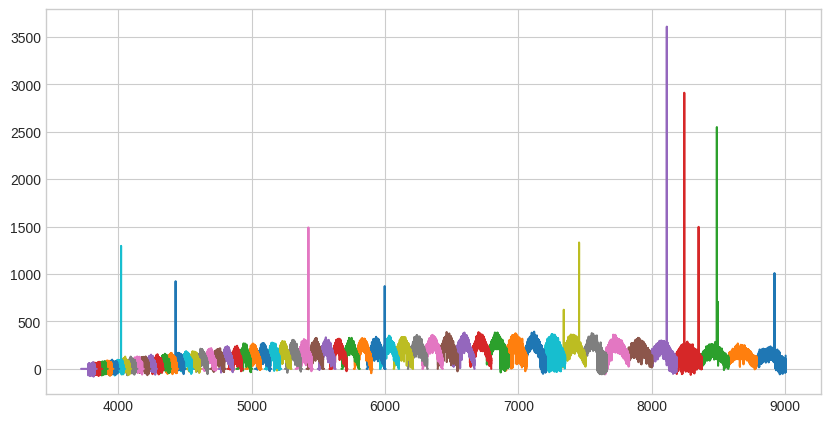

<Figure size 640x480 with 0 Axes>

In [125]:
data_1=np.transpose(fits.open('reduced/01047002_HRF_OBJ_ext.fits')[0].data)
flux_1 = np.transpose(data_1)
plt.figure(figsize=(10, 5))
plt.plot(wavelength_scale,flux_1)
plt.figure()

In [126]:
#HERMES ETC
from math import exp, sqrt, asin
import optparse

#perPixel = False  # If True: calculate flux and SNR per pixel, False: per resolution bin
perPixel = True  # If True: calculate flux and SNR per pixel, False: per resolution bin

# Colors
colors = ['U', 'B', 'V', 'R', 'I', 'Z']
# Wavelength in Angstrom
# Wavelength = {'U': 3600, 'B': 4400, 'V': 5500, 'R': 6400, 'I': 7900}
wavelength = {'U': 3800, 'B': 4400, 'V': 5500, 'R': 6400, 'I': 7900, 'Z': 8800}

# Detector:
readnoise = 5     # e-
dark = 0.0003     # e-/s

# Telescope
Dm1 = 120
Dm2 = 39
TelescopeArea = 3.14152 * (Dm1*Dm1 - Dm2*Dm2) / 4
TelescopeEff = {'U': 0.7, 'B': 0.7, 'V': 0.7, 'R': 0.66, 'I': 0.57, 'Z': 0.6}
TelescopeEffArea = {}
for color in colors:
    TelescopeEffArea[color] = TelescopeEff[color] * TelescopeArea

spectralTypes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Intrinsic colors
#UB = {'O': -1.20, 'B': -0.50, 'A': 0.10, 'F': 0.00, 'G': 0.20, 'K': 1.10, 'M': 1.30 }
UB = {'O': -0.80, 'B': -0.20, 'A': 0.10, 'F': 0.00, 'G': 0.10, 'K': 0.50, 'M': 0.70 }
BV = {'O': -0.30, 'B': -0.15, 'A': 0.20, 'F': 0.50, 'G': 0.70, 'K': 1.20, 'M': 1.70 }
VI = {'O': -0.15, 'B': -0.10, 'A': 0.15, 'F': 0.50, 'G': 0.76, 'K': 1.20, 'M': 3.00 }
RI = {'O': -0.10, 'B': -0.06, 'A': 0.08, 'F': 0.25, 'G': 0.36, 'K': 0.70, 'M': 1.80 }
ZI = {'O': -0.05, 'B': -0.03, 'A': 0.04, 'F': 0.10, 'G': 0.15, 'K': 0.40, 'M': 0.20 }
# Sky at new moon
MP_newmoon = {'U': 22.0, 'B': 22.7, 'V': 21.8, 'R': 20.9, 'I': 19.9, 'Z': 18.8}
# Sky at half moon
MP_halfmoon = {'U': 19.9, 'B': 21.6, 'V': 21.4, 'R': 20.6, 'I': 19.7, 'Z': 18.6}
# Sky at full moon
MP_fullmoon = {'U': 17.0, 'B': 19.5, 'V': 20.0, 'R': 19.9, 'I': 19.2, 'Z': 18.1}

# Atmospheric extinction [mag/airmass]
AtmExt = {'U': 0.46, 'B': 0.20, 'V': 0.11, 'R': 0.07, 'I': 0.02, 'Z': 0.01}

# Interstellar extinction [mag/E9B-V)]
IntExt = {'U': 4.7, 'B': 4.1, 'V': 3.1, 'R': 2.6, 'I': 1.9, 'Z': 1.1}

# Flux for star of magnitude 0.0 in photons
# 4.2E-9 6.6E-9 3.6E-9 2.2E-9 1.2E-9 erg/cm**2/sec/Angstrom
# [photons / cm2/sec/Angstrom]
# U@380nm ???
FluxCal = {'U': 1000, 'B': 1460, 'V': 1000, 'R': 710, 'I': 480, 'Z': 330}

# Angstrom/pixel
BinSize = {'U': 0.0205, 'B': 0.0237, 'V': 0.0294, 'R': 0.0340, 'I': 0.0419, 'Z': 0.0465}
if not perPixel:
    # Angstrom/resolution bin
    for color in colors:
        BinSize[color] = npixs * BinSize[color]

def calcFlux():            

    skymag = {}
    sky = {}
    flux = {}
    rmag = {}
    emag = {}
    PeakPixel = {}
    IntMag = {}
    totEff = {}

    # Correct intrinsic colors
    IntMag['V'] = Vmag
    IntMag['B'] = Vmag + BV[SpecType]
    IntMag['U'] = IntMag['B'] + UB[SpecType]
    IntMag['I'] = IntMag['V'] - VI[SpecType]
    IntMag['R'] = IntMag['I'] + RI[SpecType]
    IntMag['Z'] = IntMag['I'] + ZI[SpecType]

    # Compute magnitude in all colors

    Offset = IntExt['V'] * EBV
    for color in colors:
        if moon == "dark":
            skymag[color] = MP_newmoon[color]
        elif moon == "grey":
            skymag[color] = MP_halfmoon[color]
        else:
            skymag[color] = MP_fullmoon[color]

        # Mag => photons/cm2/sec/A
        sky[color] = exp(-0.92104 * skymag[color]) * FluxCal[color]
        
        sky[color] = sky[color] * FiberOmega
        sky[color] = sky[color] * obstime * TelescopeEffArea[color]
        sky[color] = sky[color] * BinSize[color]
        sky[color] = sky[color] * Efficiency[color] * OverallEfficiency


        totEff[color] = exp(-0.92104 * IntMag[color]) * FluxCal[color] * obstime * TelescopeArea * BinSize[color]
#       print totEff[color]

        rmag[color] = IntMag[color] + IntExt[color]*EBV - Offset
        emag[color] = rmag[color] + AtmExt[color] * airmass

        flux[color] = exp(-0.92104 * emag[color]) * FluxCal[color]
        flux[color] = flux[color] * obstime * TelescopeEffArea[color]
        flux[color] = flux[color] * BinSize[color]
        flux[color] = flux[color] * Efficiency[color] * OverallEfficiency
        flux[color] = flux[color] * SeeingEff
#       print flux[color]
        totEff[color] = flux[color] / totEff[color] * 100

    #    PeakPixel[color] = (flux[color] + sky[color]) * 0.67 + readnoise + dark*obstime   ???
    #    PeakPixel[color] = (flux[color] + sky[color]) * 0.23 + readnoise + dark*obstime   ???

    return (flux, sky, totEff)


def calcSnr(flux, sky):
    noisesqr = {}
    snr = {}
    for color in colors:
        noisesqr[color] = flux[color] + sky[color] + crossorderpixs*(readnoise*readnoise+dark*obstime)        
        snr[color] = flux[color] / sqrt(noisesqr[color])
#        print color, noisesqr[color], snr[color]
    return snr



p = optparse.OptionParser(description="HERMES exposure time estimator")
p.set_defaults(Vmag = 11.54,
               spectralType = "A",
               reddening = 0.0,
               fiber = "HRF",
               exptime = 1800.0,
               seeing = 1.2,
               airmass = 1.2,
               moon = "GREY",
               readnoise = 5,
               binning = "1X1"
               )
p.add_option("-f",
             action="store",
             type = "string",
             dest = "fiber",
             help = "H(RF) or L(RF), default=%default")
p.add_option("-e",
             action="store",
             type = "float",
             dest = "exptime",
             help = "Exposure time (s), default=%default")
p.add_option("-v",
             action="store",
             type = "float",
             dest = "Vmag",
             help = "Magnitude in V, default=%default")
p.add_option("-t",
             action="store",
             dest = "spectralType",
             choices = spectralTypes,
             help = "Spectral type, default=%default")
p.add_option("-r",
             action="store",
             type = "float",
             dest = "reddening",
             help = "Reddening E(B-V), default=%default")
p.add_option("-s",
             action="store",
             type = "float",
             dest = "seeing",
             help = "Seeing (arcsec), default=%default")
p.add_option("-a",
             action="store",
             type = "float",
             dest = "airmass",
             help = "Air mass, default=%default")
p.add_option("-m",
             action="store",
             dest = "moon",
             help = "B(right), G(rey), D(ark), default=%default")
p.add_option("-n",
             action="store",
             type = "float",
             dest = "readnoise",
             help = "Read noise in e-, default=%default")
p.add_option("-b",
             action="store",
             dest = "binning",
             help = "Binning (IxJ, I: spectrally, J: cross-order), default=%default")

opt, args = p.parse_args()

Vmag = opt.Vmag
obstime = opt.exptime
seeing = opt.seeing
airmass = opt.airmass
SpecType = opt.spectralType
if opt.moon[0] == "D" or opt.moon[0] == "d":
    moon = "dark"
elif opt.moon[0] == "B" or opt.moon[0] == "b":
    moon = "bright"
else:
    moon = "grey"
EBV = opt.reddening
readnoise = opt.readnoise
if opt.fiber[0] == "L" or opt.fiber[0] == "l":
    fiber = "LRF"
    FiberDiameter = 2.15
    crossorderpixs = 5
    npixs = 3.3     # wavelength bin
else:
    fiber = "HRF"
    FiberDiameter = 2.5
    crossorderpixs = 15
    npixs = 2.2     # wavelenth bin
FiberRadius = FiberDiameter / 2
FiberOmega = FiberRadius*FiberRadius * 3.14152

SeeingEff = 1.0 - exp((-FiberRadius*FiberRadius)/(2.0*(seeing/2.354)*(seeing/2.354)))

# Spectrograph efficiency
if fiber == "LRF": 
    Efficiency = {'U': 0.09, 'B': 0.16, 'V': 0.19, 'R': 0.18, 'I': 0.11, 'Z': 0.06}
else:
    Efficiency = {'U': 0.20, 'B': 0.24, 'V': 0.28, 'R': 0.21, 'I': 0.15, 'Z': 0.08}
#FEROS Efficiency = {'U': 0.01, 'B': 0.26, 'V': 0.26, 'R': 0.25, 'I': 0.17}

OverallEfficiency = 1.0

binI = float(opt.binning[0])
binJ = float(opt.binning[2])
for color in colors:
    BinSize[color] = binI*BinSize[color]
crossorderpixs = crossorderpixs / binJ


flux, sky, totEff = calcFlux()
snr = calcSnr(flux, sky)

print("Hermes %s estimated snr & flux" %(fiber))
print("Vmag: %.3f\t\t\tExposure time: %.2fs" %(Vmag, obstime))
print("Binning: %.0fx%.0f\t\t\tRead noise:) %.1fe-" %(binI, binJ, readnoise))
print("Spectral type: %s\t\tE(B-V): %.2f" %(SpecType, EBV))
print("Air mass: %.2f\t\t\tMoon: %s" %(airmass, moon))
print('Seeing: %.2f"\t\t\tSlitloss: %4.1f%s' %(seeing, (1-SeeingEff)*100,"%"))

#print "  Wavelength     SNR   Flux star    Flux sky"
print ("  Wavelength     SNR     e- star     e- sky    %Eff")
for color in colors:
    print( "  %3inm    %9.1f   %9.1f  %9.1f   %5.1f" %(wavelength[color]/10, snr[color], flux[color], sky[color], totEff[color]))

data1_efficiency = calculate_efficiency(data_1,totEff)

Hermes HRF estimated snr & flux
Vmag: 11.540			Exposure time: 1800.00s
Binning: 1x1			Read noise:) 5.0e-
Spectral type: A		E(B-V): 0.00
Air mass: 1.20			Moon: grey
Seeing: 1.20"			Slitloss:  4.9%
  Wavelength     SNR     e- star     e- sky    %Eff
  380nm         17.9       548.6        2.8     8.0
  440nm         36.2      1624.0        1.2    12.8
  550nm         42.6      2137.8        1.4    16.5
  640nm         32.9      1383.8        1.7    12.2
  790nm         23.4       809.1        2.0     7.9
  880nm         12.6       337.7        2.4     4.5
Efficiency observed: [0.         1.2505141  0.92082174 1.12051601 0.20260429 0.26886464]


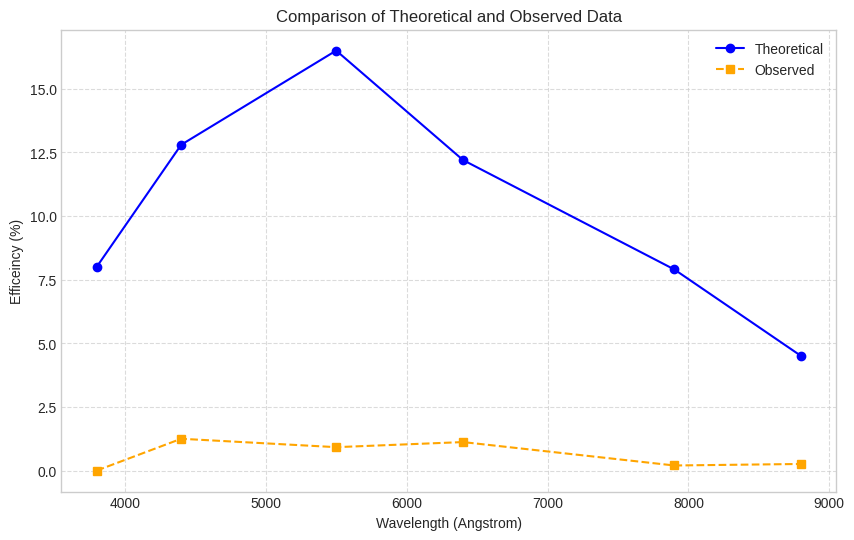

In [127]:
ETC_wavelengths = [3800, 4400, 5500, 6400, 7900, 8800]
data1_TE = [8, 12.8, 16.5, 12.2, 7.9, 4.5]
data1_CE = [0, 1.25, 0.92, 1.12, 0.20, 0.26]
plt.figure(figsize=(10, 6))
plt.plot(ETC_wavelengths, data1_TE, marker='o', linestyle='-', color='blue', label='Theoretical')
plt.plot(ETC_wavelengths, data1_CE, marker='s', linestyle='--', color='orange', label='Observed')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Efficeincy (%)')
plt.title('Comparison of Theoretical and Observed Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# HD134169

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

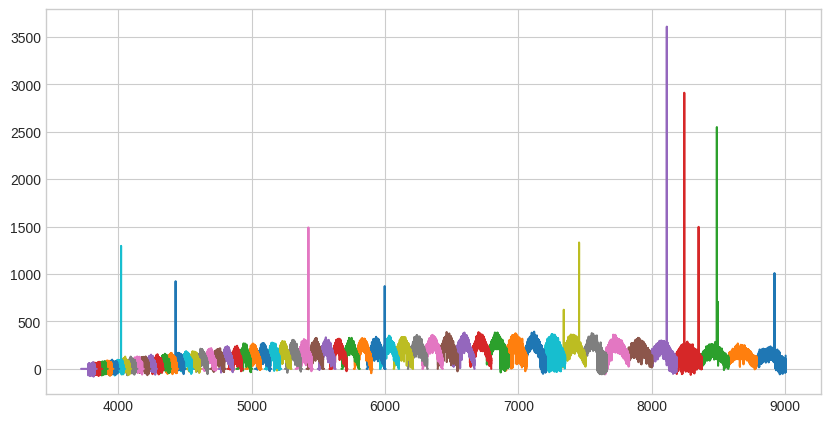

In [128]:
data_2=np.transpose(fits.open('reduced/01047002_HRF_OBJ_ext.fits')[0].data)
flux_2 = np.transpose(data_2)
plt.figure(figsize=(10, 5))
plt.plot(wavelength_scale,flux_2)
plt.figure

In [129]:
#HERMES ETC
from math import exp, sqrt, asin
import optparse

#perPixel = False  # If True: calculate flux and SNR per pixel, False: per resolution bin
perPixel = True  # If True: calculate flux and SNR per pixel, False: per resolution bin

# Colors
colors = ['U', 'B', 'V', 'R', 'I', 'Z']
# Wavelength in Angstrom
# Wavelength = {'U': 3600, 'B': 4400, 'V': 5500, 'R': 6400, 'I': 7900}
wavelength = {'U': 3800, 'B': 4400, 'V': 5500, 'R': 6400, 'I': 7900, 'Z': 8800}

# Detector:
readnoise = 5     # e-
dark = 0.0003     # e-/s

# Telescope
Dm1 = 120
Dm2 = 39
TelescopeArea = 3.14152 * (Dm1*Dm1 - Dm2*Dm2) / 4
TelescopeEff = {'U': 0.7, 'B': 0.7, 'V': 0.7, 'R': 0.66, 'I': 0.57, 'Z': 0.6}
TelescopeEffArea = {}
for color in colors:
    TelescopeEffArea[color] = TelescopeEff[color] * TelescopeArea

spectralTypes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Intrinsic colors
#UB = {'O': -1.20, 'B': -0.50, 'A': 0.10, 'F': 0.00, 'G': 0.20, 'K': 1.10, 'M': 1.30 }
UB = {'O': -0.80, 'B': -0.20, 'A': 0.10, 'F': 0.00, 'G': 0.10, 'K': 0.50, 'M': 0.70 }
BV = {'O': -0.30, 'B': -0.15, 'A': 0.20, 'F': 0.50, 'G': 0.70, 'K': 1.20, 'M': 1.70 }
VI = {'O': -0.15, 'B': -0.10, 'A': 0.15, 'F': 0.50, 'G': 0.76, 'K': 1.20, 'M': 3.00 }
RI = {'O': -0.10, 'B': -0.06, 'A': 0.08, 'F': 0.25, 'G': 0.36, 'K': 0.70, 'M': 1.80 }
ZI = {'O': -0.05, 'B': -0.03, 'A': 0.04, 'F': 0.10, 'G': 0.15, 'K': 0.40, 'M': 0.20 }
# Sky at new moon
MP_newmoon = {'U': 22.0, 'B': 22.7, 'V': 21.8, 'R': 20.9, 'I': 19.9, 'Z': 18.8}
# Sky at half moon
MP_halfmoon = {'U': 19.9, 'B': 21.6, 'V': 21.4, 'R': 20.6, 'I': 19.7, 'Z': 18.6}
# Sky at full moon
MP_fullmoon = {'U': 17.0, 'B': 19.5, 'V': 20.0, 'R': 19.9, 'I': 19.2, 'Z': 18.1}

# Atmospheric extinction [mag/airmass]
AtmExt = {'U': 0.46, 'B': 0.20, 'V': 0.11, 'R': 0.07, 'I': 0.02, 'Z': 0.01}

# Interstellar extinction [mag/E9B-V)]
IntExt = {'U': 4.7, 'B': 4.1, 'V': 3.1, 'R': 2.6, 'I': 1.9, 'Z': 1.1}

# Flux for star of magnitude 0.0 in photons
# 4.2E-9 6.6E-9 3.6E-9 2.2E-9 1.2E-9 erg/cm**2/sec/Angstrom
# [photons / cm2/sec/Angstrom]
# U@380nm ???
FluxCal = {'U': 1000, 'B': 1460, 'V': 1000, 'R': 710, 'I': 480, 'Z': 330}

# Angstrom/pixel
BinSize = {'U': 0.0205, 'B': 0.0237, 'V': 0.0294, 'R': 0.0340, 'I': 0.0419, 'Z': 0.0465}
if not perPixel:
    # Angstrom/resolution bin
    for color in colors:
        BinSize[color] = npixs * BinSize[color]

def calcFlux():            

    skymag = {}
    sky = {}
    flux = {}
    rmag = {}
    emag = {}
    PeakPixel = {}
    IntMag = {}
    totEff = {}

    # Correct intrinsic colors
    IntMag['V'] = Vmag
    IntMag['B'] = Vmag + BV[SpecType]
    IntMag['U'] = IntMag['B'] + UB[SpecType]
    IntMag['I'] = IntMag['V'] - VI[SpecType]
    IntMag['R'] = IntMag['I'] + RI[SpecType]
    IntMag['Z'] = IntMag['I'] + ZI[SpecType]

    # Compute magnitude in all colors

    Offset = IntExt['V'] * EBV
    for color in colors:
        if moon == "dark":
            skymag[color] = MP_newmoon[color]
        elif moon == "grey":
            skymag[color] = MP_halfmoon[color]
        else:
            skymag[color] = MP_fullmoon[color]

        # Mag => photons/cm2/sec/A
        sky[color] = exp(-0.92104 * skymag[color]) * FluxCal[color]
        
        sky[color] = sky[color] * FiberOmega
        sky[color] = sky[color] * obstime * TelescopeEffArea[color]
        sky[color] = sky[color] * BinSize[color]
        sky[color] = sky[color] * Efficiency[color] * OverallEfficiency


        totEff[color] = exp(-0.92104 * IntMag[color]) * FluxCal[color] * obstime * TelescopeArea * BinSize[color]
#       print totEff[color]

        rmag[color] = IntMag[color] + IntExt[color]*EBV - Offset
        emag[color] = rmag[color] + AtmExt[color] * airmass

        flux[color] = exp(-0.92104 * emag[color]) * FluxCal[color]
        flux[color] = flux[color] * obstime * TelescopeEffArea[color]
        flux[color] = flux[color] * BinSize[color]
        flux[color] = flux[color] * Efficiency[color] * OverallEfficiency
        flux[color] = flux[color] * SeeingEff
#       print flux[color]
        totEff[color] = flux[color] / totEff[color] * 100

    #    PeakPixel[color] = (flux[color] + sky[color]) * 0.67 + readnoise + dark*obstime   ???
    #    PeakPixel[color] = (flux[color] + sky[color]) * 0.23 + readnoise + dark*obstime   ???

    return (flux, sky, totEff)


def calcSnr(flux, sky):
    noisesqr = {}
    snr = {}
    for color in colors:
        noisesqr[color] = flux[color] + sky[color] + crossorderpixs*(readnoise*readnoise+dark*obstime)        
        snr[color] = flux[color] / sqrt(noisesqr[color])
#        print color, noisesqr[color], snr[color]
    return snr



p = optparse.OptionParser(description="HERMES exposure time estimator")
p.set_defaults(Vmag = 7.7,
               spectralType = "F",
               reddening = 0.0,
               fiber = "HRF",
               exptime = 28.0,
               seeing = 1.2,
               airmass = 1.4,
               moon = "GREY",
               readnoise = 5,
               binning = "1X1"
               )
p.add_option("-f",
             action="store",
             type = "string",
             dest = "fiber",
             help = "H(RF) or L(RF), default=%default")
p.add_option("-e",
             action="store",
             type = "float",
             dest = "exptime",
             help = "Exposure time (s), default=%default")
p.add_option("-v",
             action="store",
             type = "float",
             dest = "Vmag",
             help = "Magnitude in V, default=%default")
p.add_option("-t",
             action="store",
             dest = "spectralType",
             choices = spectralTypes,
             help = "Spectral type, default=%default")
p.add_option("-r",
             action="store",
             type = "float",
             dest = "reddening",
             help = "Reddening E(B-V), default=%default")
p.add_option("-s",
             action="store",
             type = "float",
             dest = "seeing",
             help = "Seeing (arcsec), default=%default")
p.add_option("-a",
             action="store",
             type = "float",
             dest = "airmass",
             help = "Air mass, default=%default")
p.add_option("-m",
             action="store",
             dest = "moon",
             help = "B(right), G(rey), D(ark), default=%default")
p.add_option("-n",
             action="store",
             type = "float",
             dest = "readnoise",
             help = "Read noise in e-, default=%default")
p.add_option("-b",
             action="store",
             dest = "binning",
             help = "Binning (IxJ, I: spectrally, J: cross-order), default=%default")

opt, args = p.parse_args()

Vmag = opt.Vmag
obstime = opt.exptime
seeing = opt.seeing
airmass = opt.airmass
SpecType = opt.spectralType
if opt.moon[0] == "D" or opt.moon[0] == "d":
    moon = "dark"
elif opt.moon[0] == "B" or opt.moon[0] == "b":
    moon = "bright"
else:
    moon = "grey"
EBV = opt.reddening
readnoise = opt.readnoise
if opt.fiber[0] == "L" or opt.fiber[0] == "l":
    fiber = "LRF"
    FiberDiameter = 2.15
    crossorderpixs = 5
    npixs = 3.3     # wavelength bin
else:
    fiber = "HRF"
    FiberDiameter = 2.5
    crossorderpixs = 15
    npixs = 2.2     # wavelenth bin
FiberRadius = FiberDiameter / 2
FiberOmega = FiberRadius*FiberRadius * 3.14152

SeeingEff = 1.0 - exp((-FiberRadius*FiberRadius)/(2.0*(seeing/2.354)*(seeing/2.354)))

# Spectrograph efficiency
if fiber == "LRF": 
    Efficiency = {'U': 0.09, 'B': 0.16, 'V': 0.19, 'R': 0.18, 'I': 0.11, 'Z': 0.06}
else:
    Efficiency = {'U': 0.20, 'B': 0.24, 'V': 0.28, 'R': 0.21, 'I': 0.15, 'Z': 0.08}
#FEROS Efficiency = {'U': 0.01, 'B': 0.26, 'V': 0.26, 'R': 0.25, 'I': 0.17}

OverallEfficiency = 1.0

binI = float(opt.binning[0])
binJ = float(opt.binning[2])
for color in colors:
    BinSize[color] = binI*BinSize[color]
crossorderpixs = crossorderpixs / binJ


flux, sky, totEff = calcFlux()
snr = calcSnr(flux, sky)

print("Hermes %s estimated snr & flux" %(fiber))
print("Vmag: %.3f\t\t\tExposure time: %.2fs" %(Vmag, obstime))
print("Binning: %.0fx%.0f\t\t\tRead noise:) %.1fe-" %(binI, binJ, readnoise))
print("Spectral type: %s\t\tE(B-V): %.2f" %(SpecType, EBV))
print("Air mass: %.2f\t\t\tMoon: %s" %(airmass, moon))
print('Seeing: %.2f"\t\t\tSlitloss: %4.1f%s' %(seeing, (1-SeeingEff)*100,"%"))

#print "  Wavelength     SNR   Flux star    Flux sky"
print ("  Wavelength     SNR     e- star     e- sky    %Eff")
for color in colors:
    print( "  %3inm    %9.1f   %9.1f  %9.1f   %5.1f" %(wavelength[color]/10, snr[color], flux[color], sky[color], totEff[color]))

data2_efficiency = calculate_efficiency(data_2,totEff)

Hermes HRF estimated snr & flux
Vmag: 7.700			Exposure time: 28.00s
Binning: 1x1			Read noise:) 5.0e-
Spectral type: F		E(B-V): 0.00
Air mass: 1.40			Moon: grey
Seeing: 1.20"			Slitloss:  4.9%
  Wavelength     SNR     e- star     e- sky    %Eff
  380nm          9.2       224.0        0.0     7.4
  440nm         20.0       634.6        0.0    12.3
  550nm         29.0      1119.6        0.0    16.2
  640nm         24.5       861.7        0.0    12.0
  790nm         19.1       594.7        0.0     7.9
  880nm          9.5       235.3        0.0     4.5
Efficiency observed: [0.         3.0845648  1.72297944 1.77632378 0.27463271 0.38515671]


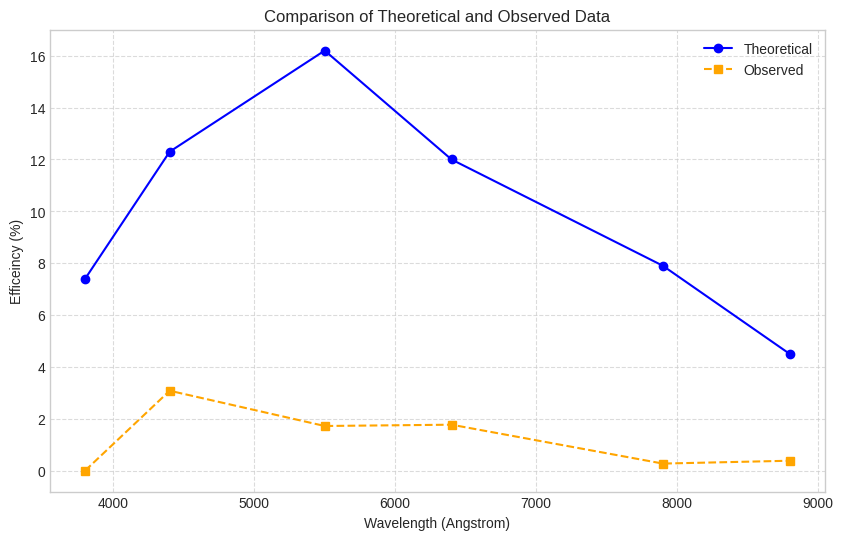

In [130]:
ETC_wavelengths = [3800, 4400, 5500, 6400, 7900, 8800]
data2_TE = [7.4, 12.3, 16.2, 12.0, 7.9, 4.5]
data2_CE = [0, 3.08, 1.72, 1.77, 0.27, 0.38]
plt.figure(figsize=(10, 6))
plt.plot(ETC_wavelengths, data2_TE, marker='o', linestyle='-', color='blue', label='Theoretical')
plt.plot(ETC_wavelengths, data2_CE, marker='s', linestyle='--', color='orange', label='Observed')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Efficeincy (%)')
plt.title('Comparison of Theoretical and Observed Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# 1047047

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

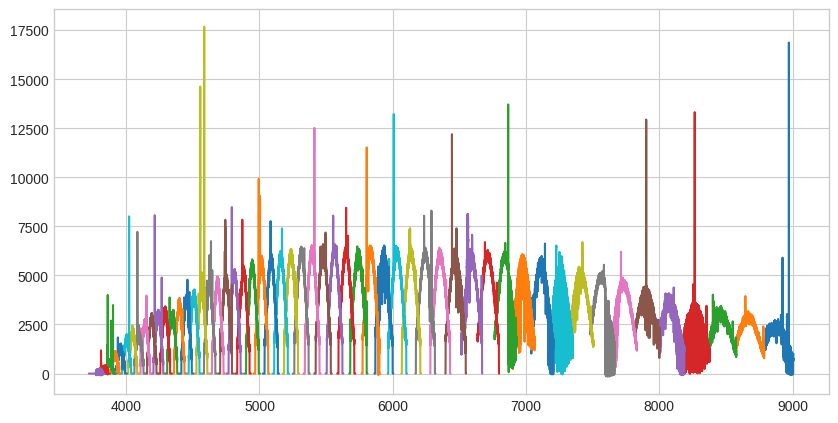

In [131]:
data_3=np.transpose(fits.open('reduced/01047047_HRF_OBJ_ext.fits')[0].data)
flux_3 = np.transpose(data_3)
plt.figure(figsize=(10,5))
plt.plot(wavelength_scale,flux_3)
plt.figure

In [132]:
#HERMES ETC
from math import exp, sqrt, asin
import optparse

#perPixel = False  # If True: calculate flux and SNR per pixel, False: per resolution bin
perPixel = True  # If True: calculate flux and SNR per pixel, False: per resolution bin

# Colors
colors = ['U', 'B', 'V', 'R', 'I', 'Z']
# Wavelength in Angstrom
# Wavelength = {'U': 3600, 'B': 4400, 'V': 5500, 'R': 6400, 'I': 7900}
wavelength = {'U': 3800, 'B': 4400, 'V': 5500, 'R': 6400, 'I': 7900, 'Z': 8800}

# Detector:
readnoise = 5     # e-
dark = 0.0003     # e-/s

# Telescope
Dm1 = 120
Dm2 = 39
TelescopeArea = 3.14152 * (Dm1*Dm1 - Dm2*Dm2) / 4
TelescopeEff = {'U': 0.7, 'B': 0.7, 'V': 0.7, 'R': 0.66, 'I': 0.57, 'Z': 0.6}
TelescopeEffArea = {}
for color in colors:
    TelescopeEffArea[color] = TelescopeEff[color] * TelescopeArea

spectralTypes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Intrinsic colors
#UB = {'O': -1.20, 'B': -0.50, 'A': 0.10, 'F': 0.00, 'G': 0.20, 'K': 1.10, 'M': 1.30 }
UB = {'O': -0.80, 'B': -0.20, 'A': 0.10, 'F': 0.00, 'G': 0.10, 'K': 0.50, 'M': 0.70 }
BV = {'O': -0.30, 'B': -0.15, 'A': 0.20, 'F': 0.50, 'G': 0.70, 'K': 1.20, 'M': 1.70 }
VI = {'O': -0.15, 'B': -0.10, 'A': 0.15, 'F': 0.50, 'G': 0.76, 'K': 1.20, 'M': 3.00 }
RI = {'O': -0.10, 'B': -0.06, 'A': 0.08, 'F': 0.25, 'G': 0.36, 'K': 0.70, 'M': 1.80 }
ZI = {'O': -0.05, 'B': -0.03, 'A': 0.04, 'F': 0.10, 'G': 0.15, 'K': 0.40, 'M': 0.20 }
# Sky at new moon
MP_newmoon = {'U': 22.0, 'B': 22.7, 'V': 21.8, 'R': 20.9, 'I': 19.9, 'Z': 18.8}
# Sky at half moon
MP_halfmoon = {'U': 19.9, 'B': 21.6, 'V': 21.4, 'R': 20.6, 'I': 19.7, 'Z': 18.6}
# Sky at full moon
MP_fullmoon = {'U': 17.0, 'B': 19.5, 'V': 20.0, 'R': 19.9, 'I': 19.2, 'Z': 18.1}

# Atmospheric extinction [mag/airmass]
AtmExt = {'U': 0.46, 'B': 0.20, 'V': 0.11, 'R': 0.07, 'I': 0.02, 'Z': 0.01}

# Interstellar extinction [mag/E9B-V)]
IntExt = {'U': 4.7, 'B': 4.1, 'V': 3.1, 'R': 2.6, 'I': 1.9, 'Z': 1.1}

# Flux for star of magnitude 0.0 in photons
# 4.2E-9 6.6E-9 3.6E-9 2.2E-9 1.2E-9 erg/cm**2/sec/Angstrom
# [photons / cm2/sec/Angstrom]
# U@380nm ???
FluxCal = {'U': 1000, 'B': 1460, 'V': 1000, 'R': 710, 'I': 480, 'Z': 330}

# Angstrom/pixel
BinSize = {'U': 0.0205, 'B': 0.0237, 'V': 0.0294, 'R': 0.0340, 'I': 0.0419, 'Z': 0.0465}
if not perPixel:
    # Angstrom/resolution bin
    for color in colors:
        BinSize[color] = npixs * BinSize[color]

def calcFlux():            

    skymag = {}
    sky = {}
    flux = {}
    rmag = {}
    emag = {}
    PeakPixel = {}
    IntMag = {}
    totEff = {}

    # Correct intrinsic colors
    IntMag['V'] = Vmag
    IntMag['B'] = Vmag + BV[SpecType]
    IntMag['U'] = IntMag['B'] + UB[SpecType]
    IntMag['I'] = IntMag['V'] - VI[SpecType]
    IntMag['R'] = IntMag['I'] + RI[SpecType]
    IntMag['Z'] = IntMag['I'] + ZI[SpecType]

    # Compute magnitude in all colors

    Offset = IntExt['V'] * EBV
    for color in colors:
        if moon == "dark":
            skymag[color] = MP_newmoon[color]
        elif moon == "grey":
            skymag[color] = MP_halfmoon[color]
        else:
            skymag[color] = MP_fullmoon[color]

        # Mag => photons/cm2/sec/A
        sky[color] = exp(-0.92104 * skymag[color]) * FluxCal[color]
        
        sky[color] = sky[color] * FiberOmega
        sky[color] = sky[color] * obstime * TelescopeEffArea[color]
        sky[color] = sky[color] * BinSize[color]
        sky[color] = sky[color] * Efficiency[color] * OverallEfficiency


        totEff[color] = exp(-0.92104 * IntMag[color]) * FluxCal[color] * obstime * TelescopeArea * BinSize[color]
#       print totEff[color]

        rmag[color] = IntMag[color] + IntExt[color]*EBV - Offset
        emag[color] = rmag[color] + AtmExt[color] * airmass

        flux[color] = exp(-0.92104 * emag[color]) * FluxCal[color]
        flux[color] = flux[color] * obstime * TelescopeEffArea[color]
        flux[color] = flux[color] * BinSize[color]
        flux[color] = flux[color] * Efficiency[color] * OverallEfficiency
        flux[color] = flux[color] * SeeingEff
#       print flux[color]
        totEff[color] = flux[color] / totEff[color] * 100

    #    PeakPixel[color] = (flux[color] + sky[color]) * 0.67 + readnoise + dark*obstime   ???
    #    PeakPixel[color] = (flux[color] + sky[color]) * 0.23 + readnoise + dark*obstime   ???

    return (flux, sky, totEff)


def calcSnr(flux, sky):
    noisesqr = {}
    snr = {}
    for color in colors:
        noisesqr[color] = flux[color] + sky[color] + crossorderpixs*(readnoise*readnoise+dark*obstime)        
        snr[color] = flux[color] / sqrt(noisesqr[color])
#        print color, noisesqr[color], snr[color]
    return snr



p = optparse.OptionParser(description="HERMES exposure time estimator")
p.set_defaults(Vmag = 8.5,
               spectralType = "B",
               reddening = 0.0,
               fiber = "HRF",
               exptime = 600,
               seeing = 1.2,
               airmass = 1.4,
               moon = "GREY",
               readnoise = 5,
               binning = "1X1"
               )
p.add_option("-f",
             action="store",
             type = "string",
             dest = "fiber",
             help = "H(RF) or L(RF), default=%default")
p.add_option("-e",
             action="store",
             type = "float",
             dest = "exptime",
             help = "Exposure time (s), default=%default")
p.add_option("-v",
             action="store",
             type = "float",
             dest = "Vmag",
             help = "Magnitude in V, default=%default")
p.add_option("-t",
             action="store",
             dest = "spectralType",
             choices = spectralTypes,
             help = "Spectral type, default=%default")
p.add_option("-r",
             action="store",
             type = "float",
             dest = "reddening",
             help = "Reddening E(B-V), default=%default")
p.add_option("-s",
             action="store",
             type = "float",
             dest = "seeing",
             help = "Seeing (arcsec), default=%default")
p.add_option("-a",
             action="store",
             type = "float",
             dest = "airmass",
             help = "Air mass, default=%default")
p.add_option("-m",
             action="store",
             dest = "moon",
             help = "B(right), G(rey), D(ark), default=%default")
p.add_option("-n",
             action="store",
             type = "float",
             dest = "readnoise",
             help = "Read noise in e-, default=%default")
p.add_option("-b",
             action="store",
             dest = "binning",
             help = "Binning (IxJ, I: spectrally, J: cross-order), default=%default")

opt, args = p.parse_args()

Vmag = opt.Vmag
obstime = opt.exptime
seeing = opt.seeing
airmass = opt.airmass
SpecType = opt.spectralType
if opt.moon[0] == "D" or opt.moon[0] == "d":
    moon = "dark"
elif opt.moon[0] == "B" or opt.moon[0] == "b":
    moon = "bright"
else:
    moon = "grey"
EBV = opt.reddening
readnoise = opt.readnoise
if opt.fiber[0] == "L" or opt.fiber[0] == "l":
    fiber = "LRF"
    FiberDiameter = 2.15
    crossorderpixs = 5
    npixs = 3.3     # wavelength bin
else:
    fiber = "HRF"
    FiberDiameter = 2.5
    crossorderpixs = 15
    npixs = 2.2     # wavelenth bin
FiberRadius = FiberDiameter / 2
FiberOmega = FiberRadius*FiberRadius * 3.14152

SeeingEff = 1.0 - exp((-FiberRadius*FiberRadius)/(2.0*(seeing/2.354)*(seeing/2.354)))

# Spectrograph efficiency
if fiber == "LRF": 
    Efficiency = {'U': 0.09, 'B': 0.16, 'V': 0.19, 'R': 0.18, 'I': 0.11, 'Z': 0.06}
else:
    Efficiency = {'U': 0.20, 'B': 0.24, 'V': 0.28, 'R': 0.21, 'I': 0.15, 'Z': 0.08}
#FEROS Efficiency = {'U': 0.01, 'B': 0.26, 'V': 0.26, 'R': 0.25, 'I': 0.17}

OverallEfficiency = 1.0

binI = float(opt.binning[0])
binJ = float(opt.binning[2])
for color in colors:
    BinSize[color] = binI*BinSize[color]
crossorderpixs = crossorderpixs / binJ


flux, sky, totEff = calcFlux()
snr = calcSnr(flux, sky)

print("Hermes %s estimated snr & flux" %(fiber))
print("Vmag: %.3f\t\t\tExposure time: %.2fs" %(Vmag, obstime))
print("Binning: %.0fx%.0f\t\t\tRead noise:) %.1fe-" %(binI, binJ, readnoise))
print("Spectral type: %s\t\tE(B-V): %.2f" %(SpecType, EBV))
print("Air mass: %.2f\t\t\tMoon: %s" %(airmass, moon))
print('Seeing: %.2f"\t\t\tSlitloss: %4.1f%s' %(seeing, (1-SeeingEff)*100,"%"))

#print "  Wavelength     SNR   Flux star    Flux sky"
print ("  Wavelength     SNR     e- star     e- sky    %Eff")
for color in colors:
    print( "  %3inm    %9.1f   %9.1f  %9.1f   %5.1f" %(wavelength[color]/10, snr[color], flux[color], sky[color], totEff[color]))

data3_efficiency = calculate_efficiency(data_3,totEff)

Hermes HRF estimated snr & flux
Vmag: 8.500			Exposure time: 600.00s
Binning: 1x1			Read noise:) 5.0e-
Spectral type: B		E(B-V): 0.00
Air mass: 1.40			Moon: grey
Seeing: 1.20"			Slitloss:  4.9%
  Wavelength     SNR     e- star     e- sky    %Eff
  380nm         68.4      5027.3        0.9     7.4
  440nm        107.1     11843.1        0.4    12.3
  550nm        105.4     11483.1        0.5    16.2
  640nm         80.1      6766.4        0.6    12.0
  790nm         56.3      3509.8        0.7     7.9
  880nm         35.5      1565.5        0.8     4.5
Efficiency observed: [0.         5.03925738 4.21091332 4.10126813 3.66365728 0.03525012]


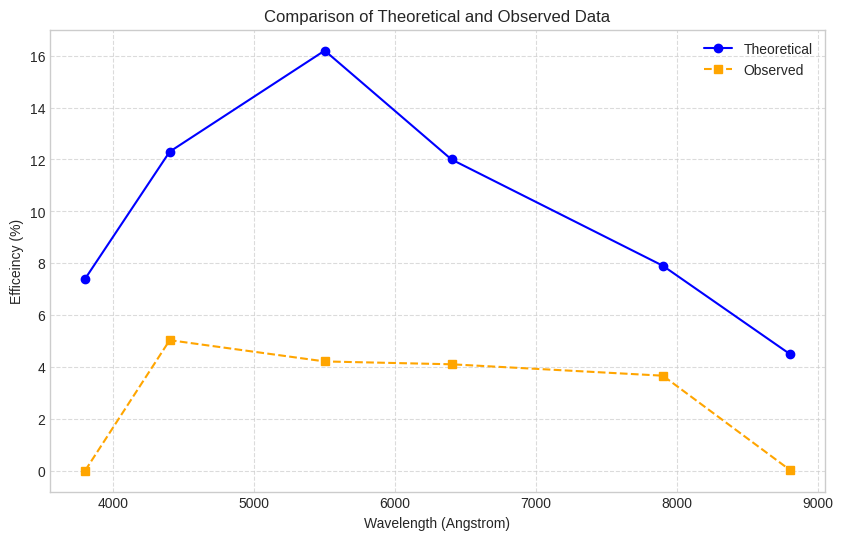

In [133]:
ETC_wavelengths = [3800, 4400, 5500, 6400, 7900, 8800]
data3_TE = [7.4, 12.3, 16.2, 12.0, 7.9, 4.5]
data3_CE = [0, 5.03, 4.21, 4.10, 3.66, 0.03]
plt.figure(figsize=(10, 6))
plt.plot(ETC_wavelengths, data3_TE, marker='o', linestyle='-', color='blue', label='Theoretical')
plt.plot(ETC_wavelengths, data3_CE, marker='s', linestyle='--', color='orange', label='Observed')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Efficeincy (%)')
plt.title('Comparison of Theoretical and Observed Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
